##### Graph generation for single image (unlabelled edges)

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import csv
from numpy import genfromtxt
from scipy.spatial import distance
import os
import glob
from pylab import *
from matplotlib.pyplot import imread
import networkx as nx

Plot sample frame (tonemap + semantic segmentation)

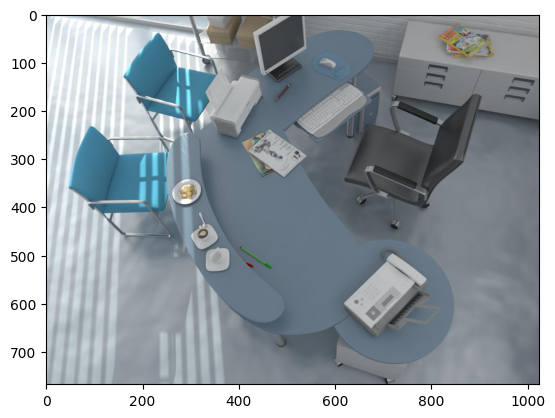

In [451]:
frame_no = 66
frame_name = "frame.0066"
scene_name = "ai_001_003"

# import sample tonemap
p = os.path.join(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads", scene_name, "images", "scene_cam_00_final_preview", frame_name + ".tonemap.jpg")
sample_tonemap_image = imread(p)

# import semantic segmentation of sample image
semantic_inst_path = os.path.join(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads", scene_name, "images", "scene_cam_00_geometry_hdf5", frame_name+".semantic_instance.hdf5")
with h5py.File(semantic_inst_path, "r") as f: semantic_inst = f['dataset'][:]

plt.imshow(sample_tonemap_image)
# plt.imshow(semantic_inst)

Import data for all 99 frames

In [452]:
# import camera positions + orientations files
camera_positions_path = os.path.join(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads", scene_name, r"_detail\cam_00\camera_keyframe_positions.hdf5")
camera_orientations_path = os.path.join(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads", scene_name, r"_detail\cam_00\camera_keyframe_orientations.hdf5")
# camera_positions_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_positions.hdf5"
# camera_orientations_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_orientations.hdf5"

# import bb information
downloads_dir = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads"
bb_size_path = os.path.join(downloads_dir, scene_name, r"_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_extents.hdf5")
bb_orientation_path = os.path.join(downloads_dir, scene_name, "_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_orientations.hdf5")
bb_position_path = os.path.join(downloads_dir, scene_name, "_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_positions.hdf5")
# bb_names = ...

# import bb label information (will be grouped under bb_names)
evermotion_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes"
mesh_objects_si_path = os.path.join(evermotion_path, scene_name, r"_detail\mesh\mesh_objects_si.hdf5")
mesh_objects_sii_path = os.path.join(evermotion_path, scene_name, r"_detail\mesh\mesh_objects_sii.hdf5")
metadata_objects_path = os.path.join(evermotion_path, scene_name, r"_detail\mesh\metadata_objects.csv")
nyu_labels_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\code\cpp\tools\scene_annotation_tool\semantic_label_descs.csv"

with h5py.File(camera_positions_path, "r") as f: camera_positions = f['dataset'][:]
with h5py.File(camera_orientations_path, "r") as f: camera_orientations = f['dataset'][:]

with h5py.File(bb_size_path, "r") as f: bb_sizes = f['dataset'][:]
with h5py.File(bb_orientation_path, "r") as f: bb_orientations = f['dataset'][:]
with h5py.File(bb_position_path, "r") as f: bb_positions = f['dataset'][:]

with h5py.File(mesh_objects_si_path, "r") as f: mesh_objects_si = f['dataset'][:]
with h5py.File(mesh_objects_sii_path, "r") as f: mesh_objects_sii = f['dataset'][:]
metadata_objects = genfromtxt(metadata_objects_path, delimiter=None, dtype=str)
nyu_labels = genfromtxt(nyu_labels_path, delimiter=',', dtype=None, encoding=None, autostrip=True)

In [453]:
# import asset to meters unit conversion
with open(os.path.join(downloads_dir, scene_name, r"_detail\metadata_scene.csv"), newline='') as csvfile:
    metadata_scene = list(csv.reader(csvfile))
    a2m = float(metadata_scene[1][1])

In [454]:
n_bb = bb_positions.shape[0] - 1 # 1st element of bb_positions is inf

In [455]:
bb_orientations.shape

(106, 3, 3)

Compute BB volumes and sort by size

Extract data for the first frame only

In [456]:
sample_camera_orientation = camera_orientations[frame_no]
sample_camera_position = camera_positions[frame_no]

R_world_from_cam = matrix(sample_camera_orientation)
t_world_from_cam = matrix(sample_camera_position).T
R_cam_from_world = R_world_from_cam.T
t_cam_from_world = -R_cam_from_world*t_world_from_cam

height_pixels = sample_tonemap_image.shape[0] 
width_pixels  = sample_tonemap_image.shape[1]

fov_x = pi/3.0
fov_y = 2.0 * arctan(height_pixels * tan(fov_x/2.0) / width_pixels)
near = 1.0
far = 1000.0

f_h    = tan(fov_y/2.0)*near # focal length in h??
f_w    = f_h*width_pixels/height_pixels
left   = -f_w
right  = f_w
bottom = -f_h
top    = f_h

Construct world to screen projection matrix

In [457]:
# Construct M (projection matrix mapping from camera view to clip view)
M_proj      = matrix(zeros((4,4)))
M_proj[0,0] = (2.0*near)/(right - left)
M_proj[1,1] = (2.0*near)/(top - bottom)
M_proj[0,2] = (right + left)/(right - left)
M_proj[1,2] = (top + bottom)/(top - bottom)
M_proj[2,2] = -(far + near)/(far - near)
M_proj[3,2] = -1.0
M_proj[2,3] = -(2.0*far*near)/(far - near)

# Construct world to screen matrix
def transform_point_screen_from_world(p_world):
    # projection matrix for: from P_world to P_cam
    p_cam      = t_cam_from_world + R_cam_from_world*p_world
    p_cam_     = matrix(r_[ p_cam.A1, 1 ]).T
    p_clip     = M_proj*p_cam_
    # projection matrix for: from P_world to P_ndc
    p_ndc      = p_clip/p_clip[3]
    p_ndc_     = p_ndc.A1
    p_screen_x = 0.5*(p_ndc_[0]+1)*(width_pixels-1)
    p_screen_y = (1 - 0.5*(p_ndc_[1]+1))*(height_pixels-1)
    p_screen_z = (p_ndc_[2]+1)/2.0 # why is there a z-component in screen coords?
    p_screen   = matrix([p_screen_x, p_screen_y, p_screen_z]).T
    return p_screen

Assign label to each BB. This is valid for all frames of this scene.

In [458]:
bb_labels = [] #TODO should make this an array (faster to process and all datatypes are the same ie. string)
no_nyu = []
bb_error = []

for i in range(n_bb):
    instances = np.where(mesh_objects_sii == i+1)[0] # low-level objects belonging to BB i+1
    # print(instances.size)
    if instances.size > 0:
        id = mesh_objects_si[instances[0]] # all low-level objects belonging to same BB should have the same label, so just take the 1st one
        if i == 31:
            print(id)
        if id == 40 or id == 39 or id == 38 or id == -1 or id == 23: # id 23 removes all "book" instances
            bb_labels.append(metadata_objects[instances[-1]]) # assign low-level object name to the bounding box when there is no NYU label available
            no_nyu.append(i+1) # BBs which do not have a matching NYU label
            # print(np.where(mesh_objects_sii == i+1)[0])
            # print(f"-> possible choices: {metadata_objects[instances]}, assigned low-lvl name {metadata_objects[instances[-1]]}")
        else:
            bb_labels.append(nyu_labels[int(id)][1]) # assign (more general) NYU label rather than low-level object label
            # print(f"-> assigned {nyu_labels[int(id)][1]} instead of {metadata_objects[instances[0]]}")
    else:
        print(f"BB {i+1} does not exist")
        bb_error.append(i+1)
        # no_nyu.append(i+1)
        bb_labels.append(np.nan)
    # print(i, bb_labels[i])


# no_nyu = np.array(no_nyu)
print(bb_error)
print("\n no nyu label:", no_nyu)
print(f"\n Number of BBs: {len(bb_labels)} \n")
print(f"BB labels: {bb_labels}") # labels for each BB

BB 29 does not exist
[-1]
BB 35 does not exist
BB 43 does not exist
BB 102 does not exist
[29, 35, 43, 102]

 no nyu label: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 57, 58, 59, 60, 62, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]

 Number of BBs: 105 

BB labels: ['chair', 'chair', 'shelves', 'boxes2_obj_19', 'boxes2_obj_18', 'boxes2_obj_17', 'boxes2_obj_16', 'boxes2_obj_15', 'boxes2_obj_14', 'boxes2_obj_13', 'boxes2_obj_11', 'boxes2_obj_10', 'boxes2_obj_09', 'boxes2_obj_08', 'boxes2_obj_07', 'boxes2_obj_12', 'box', 'box', 'box', 'LCD_obj_06', 'LCD_obj_01', 'mouse_obj_02', 'pen_obj_15', 'printer_obj_07', 'keyboard_obj_05', 'list_02', 'newspaper_01', 'cookie13', nan, 'cookie07', 'coofe_obj_05', 'cookie04', 'storage_obj_49', 'cookie02', nan, 'cookie06', 'cookie12',

In [459]:
for i, label in enumerate(bb_labels):
    if label == "otherprop":
        print(i)
np.where(mesh_objects_sii == 31)
mesh_objects_si[324]

array([40], dtype=int64)

Filter which BB are present in the sample image (mask)

In [460]:
bb_in_sample = unique(semantic_inst)
# print(bb_in_sample)
if bb_in_sample[0] == -1:
    # print(bb_in_sample)
    bb_in_sample = bb_in_sample[1:]

n_bb_in_sample = bb_in_sample.shape[0]
# print(bb_in_sample)

# bb_in_sample_mask = np.zeros((n_bb, n_bb), dtype=int)
# for bb_id in bb_in_sample:
#     bb_in_sample_mask[bb_id-1, bb_id-1] = 1

Create distance mask

In [461]:
any(np.isinf(bb_positions[29])) == True

True

In [462]:
distance_threshold_m = 1.5
bb_position_m = bb_positions*a2m

n_bb = bb_positions.shape[0]-1
bb_distances = np.zeros((n_bb, n_bb))
bb_distances[:, :] = np.nan

for i in range(n_bb):
    for j in range(n_bb):
        if i+1 not in bb_error and j+1 not in bb_error:
            bb_distances[i, j] = distance.euclidean(bb_position_m[i+1, :], bb_position_m[j+1, :])

# In case the chosen threshold is too large: (ie. no objects are this close by)
# bb_distances_copy = bb_distances
# np.fill_diagonal(bb_distances_copy, np.max(bb_distances)) #remove 0-elements along the diagonal
# # print(np.min(bb_distances_copy)) # find the minimum distance between 2 objects
# if np.min(bb_distances_copy) > distance_threshold_m: # change threshold if it is too small
#     distance_threshold_m = np.min(bb_distances_copy)

distance_mask = (bb_distances <= distance_threshold_m)*int(1) # True for objects that are within [threshold] m of other objects
np.fill_diagonal(distance_mask, 0)
np.sum(distance_mask)

3110

Project BB centres (positions) from world -> 2D screen for this frame only

In [463]:
bb_pos = {}
for i in bb_in_sample:
    bb_position_ = expand_dims(bb_positions[i], 1)
    bb_position_screen = transform_point_screen_from_world(bb_position_)
    x = np.ravel(bb_position_screen[0])
    x = x.astype(int)
    x = x.item()
    y = np.ravel(bb_position_screen[1])
    y = y.astype(int)
    y = y.item()
    y = - y + height_pixels
    x = np.clip(x, 0, width_pixels) #clip to edge
    y = np.clip(y, 0, height_pixels) #clip to edge
    # y = - y - height_pixels
    bb_pos[i] = (x, y)
# bb_pos

In [464]:
bb_positions

array([[          inf,           inf,           inf],
       [  46.52349485, -152.74755564,   13.89422677],
       [  80.78834476, -151.35538175,   13.89422677],
       [ 114.66921959, -160.40642767,   16.6718874 ],
       [ 114.63109589, -169.54603577,   37.20245552],
       [ 114.98888397, -169.96510315,   36.61190224],
       [ 114.4361496 , -169.2893219 ,   36.02134895],
       [ 114.73229218, -169.2580719 ,   35.4308033 ],
       [ 114.49791718, -169.2144928 ,   34.84024239],
       [ 114.63109589, -169.54603577,   34.24969673],
       [ 114.63109589, -169.54603577,   33.65915108],
       [ 114.68808746, -160.15101624,   29.66456699],
       [ 115.25534821, -160.81471252,   29.07401371],
       [ 114.95993805, -160.85243225,   28.48346043],
       [ 115.19522858, -160.89076233,   27.89290714],
       [ 115.05484772, -160.56214905,   27.30235386],
       [ 115.05484772, -160.56214905,   26.7118082 ],
       [ 113.7640255 , -153.26176317,   18.57546711],
       [ 113.76283421, -153.

Graph nodes for this frame

In [465]:
def remove_no_nyu(bb_not_in_sample, no_nyu):
    bb_not_in_sample = bb_not_in_sample.tolist()
    for i in range(len(no_nyu)):
        if no_nyu[i] not in bb_not_in_sample:
            bb_not_in_sample.append(no_nyu[i])
    bb_not_in_sample.sort()
    bb_not_in_sample = np.array(bb_not_in_sample)
    return bb_not_in_sample

In [466]:
def remove_small_objects(n_bb, bb_sizes, bb_not_in_sample, n_remove = 15):
    volumes_au = np.zeros(n_bb)
    for i in range(n_bb):
        volumes_au[i] = bb_sizes[i+1, 0] * bb_sizes[i+1, 1] * bb_sizes[i+1, 0] * bb_sizes[i+1, 2]
    vol_sorted_idx = np.argsort(volumes_au)
    bb_not_in_sample = bb_not_in_sample.tolist()
    for i in range(n_remove):
        if vol_sorted_idx[i] not in bb_not_in_sample:
            bb_not_in_sample.append(vol_sorted_idx[i])
    bb_not_in_sample.sort()
    bb_not_in_sample = np.array(bb_not_in_sample)
    return bb_not_in_sample

In [467]:
print(bb_in_sample)

[  1   2   3  17  18  19  20  21  22  23  24  25  26  27  28  30  31  32
  33  34  36  37  38  39  40  41  42  44  45  46  47  49  50  51  52  53
  54  55  56  57  58  59 103]


In [468]:
temp = arange(1,n_bb+1) # goes from 1 to 55
bb_not_in_sample = np.delete(temp, bb_in_sample - np.ones(len(bb_in_sample), dtype=int))
bb_not_in_sample = remove_no_nyu(bb_not_in_sample, no_nyu)
# bb_not_in_sample = remove_small_objects(n_bb, bb_sizes, bb_not_in_sample, n_remove=40)
print(bb_not_in_sample)

adjacency_matrix = distance_mask
index = bb_not_in_sample - np.ones(len(bb_not_in_sample), dtype=int)

adjacency_matrix[index,:] = np.zeros((len(bb_not_in_sample), n_bb))
adjacency_matrix[:, index] = np.zeros((n_bb, len(bb_not_in_sample)))

[  4   5   6   7   8   9  10  11  12  13  14  15  16  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 104 105]


43 43


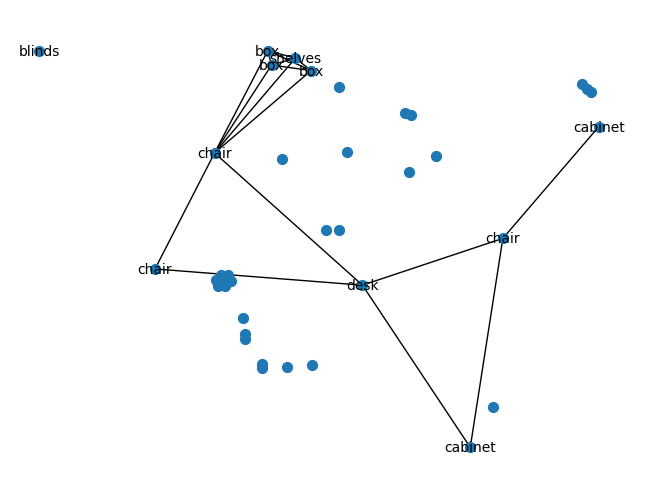

In [469]:
temp = arange(1,n_bb+1)
bb_in_sample_nodes = np.delete(temp, bb_not_in_sample - np.ones(len(bb_not_in_sample), dtype=int))

node_labels_dict = {}
for i in bb_in_sample_nodes:
    node_labels_dict[i] = bb_labels[i-1]

rows, cols = np.where(adjacency_matrix == 1)
rows= rows + 1
cols= cols + 1
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()

gr.add_nodes_from(bb_in_sample)
gr.add_edges_from(edges)

# nx.draw(gr, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)
nx.draw(gr, pos=bb_pos, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)
print(len(gr.nodes), len(bb_in_sample))
plt.show()


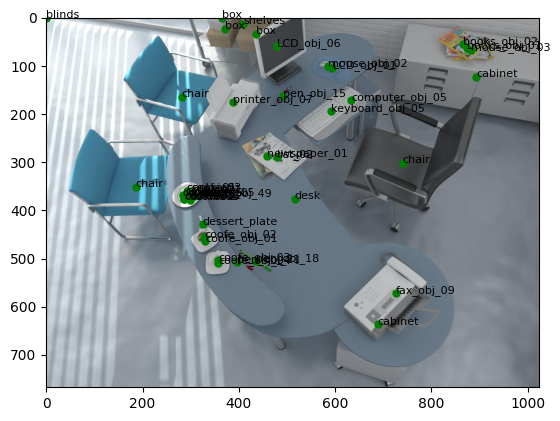

In [470]:
# from mpl_interactions import ioff, panhandler, zoom_factory
# %matplotlib widget

# with plt.ioff():
#     fig, ax = plt.subplots()

# ax.imshow(sample_tonemap_image)
plt.imshow(sample_tonemap_image) ###
x=[]
y=[]
for i in bb_in_sample:
    centre = transform_point_screen_from_world(expand_dims(bb_positions[i], 1))
    xi = np.clip(centre[0].item(), 0, width_pixels)
    yi = np.clip(centre[1].item(), 0, height_pixels)
    x.append(xi)
    y.append(yi)
plt.plot(x, y, "og", markersize=5)
for i, bb in enumerate(bb_in_sample):
    plt.text(x[i], y[i], bb_labels[bb-1], fontsize=8)

# disconnect_zoom = zoom_factory(ax)
# display(fig.canvas)

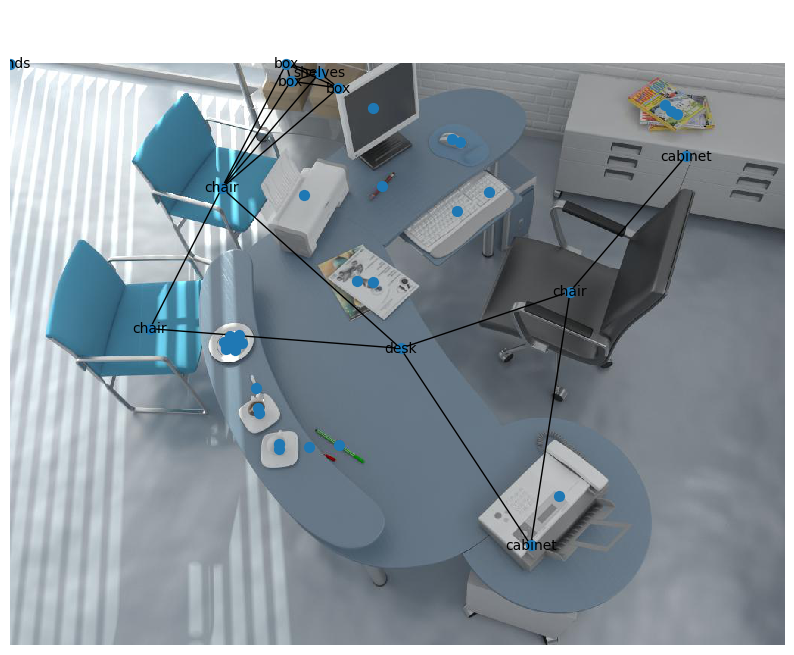

In [471]:
y_lim, x_lim = sample_tonemap_image.shape[:-1]
extent = 0, x_lim, 0, y_lim

fig = plt.figure(figsize=(10,10))
plt.imshow(sample_tonemap_image, extent=extent, interpolation='nearest')
nx.draw(gr, pos=bb_pos, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)
# plt.show()
plt.savefig("graph_frame_" + scene_name + "_" + str(frame_no))

In [518]:
pts_for_3d = bb_positions[bb_in_sample]*a2m
# x_for_3d = pts_for_3d[:,0]

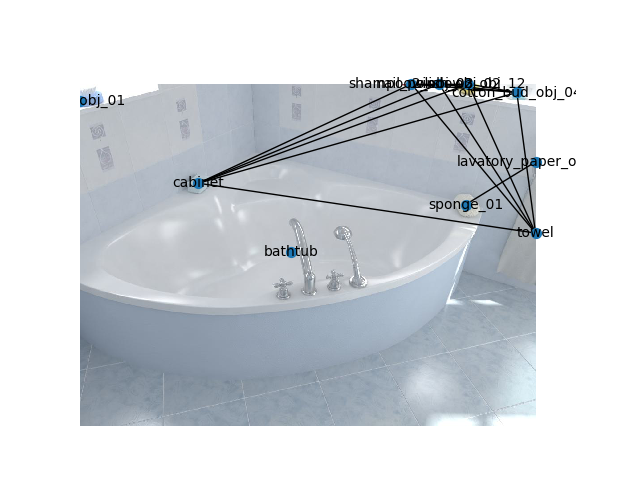

In [118]:
# from mpl_interactions import ioff, panhandler, zoom_factory
# %matplotlib widget

# with plt.ioff():
#     fig, ax = plt.subplots()

# y_lim, x_lim = sample_tonemap_image.shape[:-1]
# extent = 0, x_lim, 0, y_lim

# ax.imshow(sample_tonemap_image, extent=extent, interpolation='nearest')
# nx.draw(gr, pos=bb_pos, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)

# disconnect_zoom = zoom_factory(ax)
# display(fig.canvas)

loaded  frame.0000.tonemap.jpg and  frame.0000.semantic_instance.hdf5


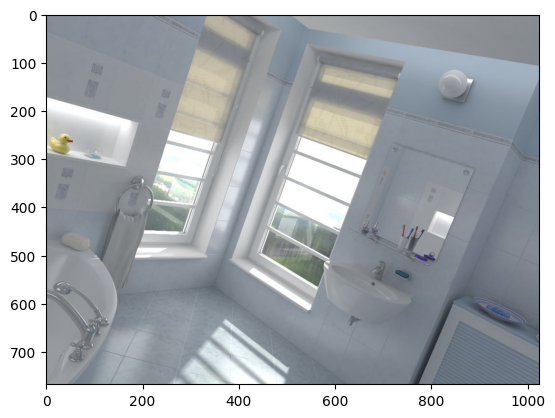

loaded  frame.0001.tonemap.jpg and  frame.0001.semantic_instance.hdf5


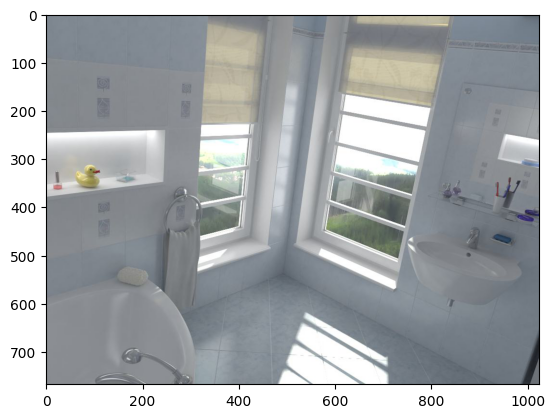

loaded  frame.0002.tonemap.jpg and  frame.0002.semantic_instance.hdf5


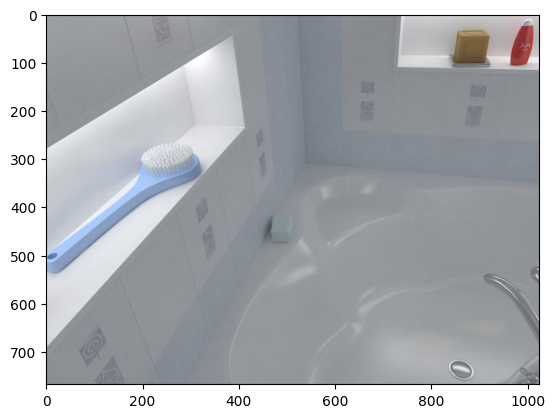

loaded  frame.0003.tonemap.jpg and  frame.0003.semantic_instance.hdf5


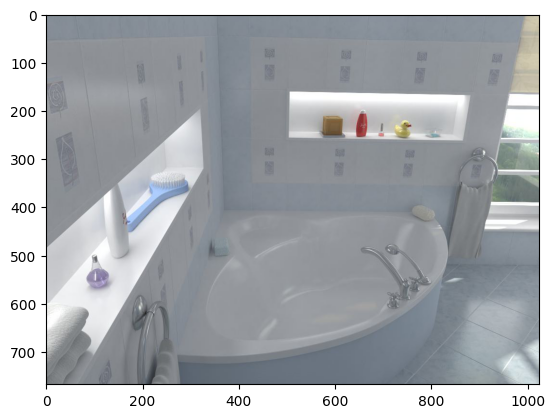

loaded  frame.0004.tonemap.jpg and  frame.0004.semantic_instance.hdf5


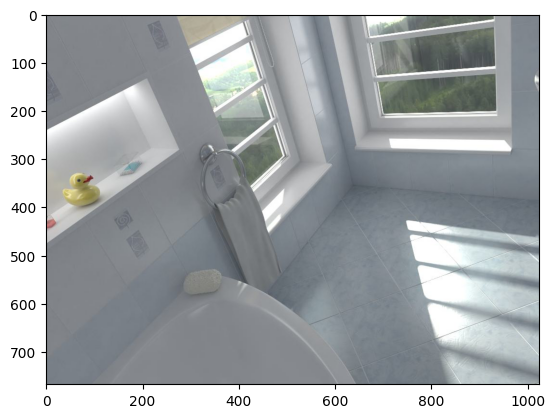

loaded  frame.0005.tonemap.jpg and  frame.0005.semantic_instance.hdf5


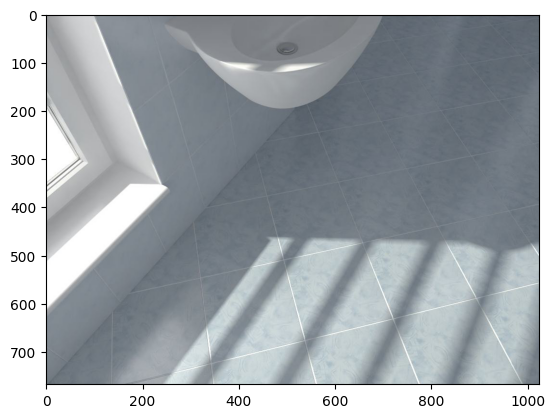

In [43]:
scene_dir = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001"
camera_name = r"cam_00"

images_dir = os.path.join(scene_dir, "images")
preview_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview")
tonemap_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview", "frame.*.tonemap.jpg")
geometry_files = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5")
segmentation_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.*.semantic_instance.hdf5")

filenames_tonemap = [ os.path.basename(f) for f in sort(glob.glob(tonemap_files_dir)) ]
filenames_segmentation = [ os.path.basename(f) for f in sort(glob.glob(segmentation_files_dir)) ]

n_frames = 6
for tonemap_file, segmentation_file, i in zip(filenames_tonemap[:n_frames], filenames_segmentation[:n_frames], arange(n_frames)):
    tonemap_dir = os.path.join(preview_files_dir, tonemap_file)
    segmentation_dir =  os.path.join(geometry_files, segmentation_file)

    tonemap = imread(tonemap_dir)
    with h5py.File(segmentation_dir, "r") as f: segmentation = f['dataset'][:]
    print("loaded ", tonemap_file, "and ", segmentation_file)

    # plt.imshow(tonemap)
    # plt.show()

    